In [1]:
from tensorflow.keras.datasets import boston_housing

In [2]:
# Load data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
# Inspect data
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [6]:
# Inspect training labels
train_targets[:5]

array([15.2, 42.3, 50. , 21.1, 17.7])

# Preparing the Data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization.

- For each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit stanrd deviation. This easily done in Numpy.

In [7]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [8]:
# Building the network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [9]:
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

### Note:

The network ends with a single unit and no activation (it will be a linear layer). This is
a typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). Applying an activation function would constrain the range the output
can take. Here, because the last
layer is purely linear, the network is free to learn to predict values in any range.

In [10]:
# K-fold validation

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [11]:
for i in range(k):
    print(f'processing fold #{i}')
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Builds the Keras model (already compiled)
    model = build_model()
    
    # Trains the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evaluates the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [12]:
all_scores

[2.0780966, 2.8664227, 2.4396489, 2.4008832]

In [13]:
# Average of mae scores
np.mean(all_scores)

2.4462628

### Saving the validation logs at each fold

In [20]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    # Prepares the validation data: data from partition #k
    print(f'processing fold #{i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Builds the Keras model (already compiled)
    model = build_model()
    
    # Trains the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [19]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [21]:
# Building the history of successive mean K-fold validation scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

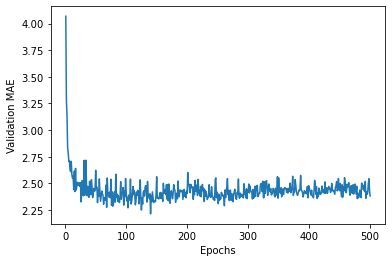

In [22]:
# Plotting validation scores

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Note:

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let's do the following:

- Omit the first 10 data points, which are on a different scale than the rest of the curve.
- REplace each point with an exponential moving average of the previous points, to obtain a smooth curve.

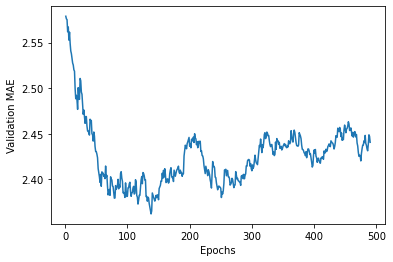

In [23]:
# Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Removing the first 10 data points
smooth_mae_history = smooth_curve(average_mae_history[10:])

# Plotting the smoothed curve
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
# Training the final model
model = build_model()
model.fit(train_data, train_targets, epochs=120, batch_size=16)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

Train on 404 samples
Epoch 1/120
404/404 [==============================] - 0s 1ms/sample - loss: 544.5853 - mae: 21.5147
Epoch 2/120
404/404 [==============================] - 0s 205us/sample - loss: 407.6229 - mae: 18.1414
Epoch 3/120
404/404 [==============================] - 0s 161us/sample - loss: 201.6647 - mae: 11.7193
Epoch 4/120
404/404 [==============================] - 0s 196us/sample - loss: 71.7274 - mae: 6.2943
Epoch 5/120
404/404 [==============================] - 0s 197us/sample - loss: 42.9655 - mae: 4.7177
Epoch 6/120
404/404 [==============================] - 0s 236us/sample - loss: 30.5727 - mae: 3.8907
Epoch 7/120
404/404 [==============================] - 0s 136us/sample - loss: 25.8082 - mae: 3.5680
Epoch 8/120
404/404 [==============================] - 0s 166us/sample - loss: 22.9057 - mae: 3.3798
Epoch 9/120
404/404 [==============================] - 0s 176us/sample - loss: 20.9094 - mae: 3.3030
Epoch 10/120
404/404 [==============================] - 0s 191us/s

404/404 [==============================] - 0s 225us/sample - loss: 5.8487 - mae: 1.7323
Epoch 82/120
404/404 [==============================] - 0s 227us/sample - loss: 5.7935 - mae: 1.7180
Epoch 83/120
404/404 [==============================] - 0s 176us/sample - loss: 5.8055 - mae: 1.7306
Epoch 84/120
404/404 [==============================] - 0s 158us/sample - loss: 5.6981 - mae: 1.7058
Epoch 85/120
404/404 [==============================] - 0s 200us/sample - loss: 5.7359 - mae: 1.7158
Epoch 86/120
404/404 [==============================] - 0s 225us/sample - loss: 5.5650 - mae: 1.7043
Epoch 87/120
404/404 [==============================] - 0s 161us/sample - loss: 5.6085 - mae: 1.6955
Epoch 88/120
404/404 [==============================] - 0s 168us/sample - loss: 5.6750 - mae: 1.7052
Epoch 89/120
404/404 [==============================] - 0s 158us/sample - loss: 5.4393 - mae: 1.6661
Epoch 90/120
404/404 [==============================] - 0s 161us/sample - loss: 5.4500 - mae: 1.6578
Epo

2.7233753